#PK_W281_Vision_Transformers_Pre_Trained_Fine_Tuned_Fine_Labels_Checkpoints_Cifar100.ipynb

W281 Final Project

April 17, 2023

Waqas Ali | Pedro Melendez | Prakash Krishnan

### Introduction

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. Its quite a simple concept, really...

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

> Indented block



![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)





CIFAR-200 Dataset Summary

This dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). 

Data Fields

    image: 32 by 32 RGB image 
    fine label: an integer code specifying the fine label class
    coarse label: mapping of a fine label to a coarse or super-class

Fine Label to Coarse Label Mapping

    mapping = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
    }


Model Details

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. 

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. Next, the model was fine-tuned on ImageNet (also referred to as ILSVRC2012), a dataset comprising 1 million images and 1,000 classes, also at resolution 224x224.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import time
import cv2

import glob
import os

import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score

from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

!pip install datasets transformers torch 

2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.9 MB/s eta 0:00:00


# Load Dataset from Hugging Face

In [ ]:
# import CIFAR-100 dataset from HuggingFace

from datasets import load_dataset

dataset_train = load_dataset(
    'cifar100',
    split='train' # training dataset
  # set to True if seeing splits Error
)


# Inspect Train Dataset Shape
display(dataset_train)


dataset_test = load_dataset(
    'cifar100',
    split='test' # training dataset
    )

# Inspect Test Dataset Shape
display(dataset_test)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142. Subsequent calls will reuse this data.


Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 10000
})

datasets.arrow_dataset.Dataset

(50000, 3)

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FB36337C5B0>,
 'fine_label': 19,
 'coarse_label': 11}

{'img': Image(decode=True, id=None),
 'fine_label': ClassLabel(names=['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'tra

PIL.PngImagePlugin.PngImageFile

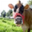

int

11

In [ ]:
# Inspect Train Dataset
# Inspect Data

display(type(dataset_train))
display(dataset_train.shape)
display(dataset_train[0])
display(dataset_train.features)
print("")

# inspect first row
image = dataset_train["img"][0]
display(type(image))
display(image)

label = dataset_train["coarse_label"][0]
display(type(label))
display(label)

In [ ]:
# check how many labels/number of classes

num_classes = len(set(dataset_train['fine_label']))
labels = dataset_train.features['fine_label']
num_classes, labels

(100,
 ClassLabel(names=['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 

# Loading ViT Feature Extractor

We use google/vit-base-patch16-224-in21k model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224. 



In [ ]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)


/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# You can see the feature extractor configuration by printing it

feature_extractor 

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Test the Mechanics of the Feature Extractor

In [ ]:
# Pre-Process the raw image of 32 by 32
# pass the first image thru the feature extractor
# returns a pytorch tensors
# returns a dictionary with a single tensor

example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example


{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          ...,
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824],
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824],
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          ...,
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569],
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569],
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  0.3098,  0.3098,  0.3098],
          [ 1

In [ ]:
# Inspect the shape (one image, 3 channels, pixel values)
display(example['pixel_values'].shape)

# original image shape and size
display(dataset_train[0]['img'].size)

# YOU CAN SEE THE FEATURE EXTRACTOR RESIZES THE IMAGE FROM 32 by 32


torch.Size([1, 3, 224, 224])

(32, 32)

# Setup GPU

In [ ]:
# load in relevant libraries, and alias where appropriate
# This block of code ensures we run it on GPU and NOT CPU

import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Data Pre-Processing for Vision Transformers

In [ ]:

def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )

    # include the labels
    inputs['fine_label'] = batch['fine_label']
    return inputs

In [ ]:
# Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)

# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)


In [ ]:
# Inspect prepared_train and prepared_test

display(prepared_train[0])
display(prepared_train)

{'pixel_values': tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.4275,  0.4275,  0.4275],
          ...,
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824],
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824],
          [-0.3176, -0.3176, -0.3176,  ...,  0.0824,  0.0824,  0.0824]],
 
         [[ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5216,  0.5216,  0.5216],
          ...,
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569],
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569],
          [-0.0431, -0.0431, -0.0431,  ...,  0.3569,  0.3569,  0.3569]],
 
         [[ 1.0000,  1.0000,  1.0000,  ...,  0.3098,  0.3098,  0.3098],
          [ 

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

# Model Fine Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['fine_label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*. 

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)). 

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [ ]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-14-b7bbca42f0bd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./cifar", # output_dir (:obj:`str`): The output directory where the model predictions and checkpoints will be written.
  per_device_train_batch_size=16, # per_device_train_batch_size (:obj:`int`, `optional`, defaults to 8): The batch size per GPU/TPU core/CPU for training.
  evaluation_strategy="steps", # :obj:`"steps"`: Evaluation is done (and logged) every :obj:`eval_steps`.
  num_train_epochs=4, # Use 4
  save_steps=100, # Number of updates steps before two checkpoint saves. (Use 100)
  eval_steps=100, # Use 100
  logging_steps=10, # Number of update steps between two logs.
  learning_rate=2e-4, # learning_rate (:obj:`float`, `optional`, defaults to 5e-5):
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add num_labels on init so the model creates a classification head with the right number of units.

In [ ]:
# VERY IMPORTANT ENTER THE NUMBER OF LABELS OR CLASSES

from transformers import ViTForImageClassification

labels = dataset_train.features['fine_label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels) # SEE NOTE ABOVE
)

num_labels=len(labels)
display(model_id, num_labels)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'google/vit-base-patch16-224-in21k'

100

In [ ]:
# Assign to GPU

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Setup Trainer Class

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

# Train the Model

In [ ]:
# Mount drive for saving model checkpoints 

from google.colab import drive
drive.mount('/content/drive')

filepath = 'drive/My Drive/Prakash_W281_Final_Project/CIFAR_100/my_model/fine_model'

Mounted at /content/drive


In [ ]:

train_results = trainer.train()
# save tokenizer with the model
trainer.save_model(filepath)
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,4.371900,4.325358,0.124400
200,3.278400,3.232959,0.466600
300,2.473400,2.397002,0.648800
400,1.913300,1.924794,0.673300
500,1.290000,1.507749,0.698500
600,1.214200,1.249085,0.736700
700,1.077600,1.124325,0.744900
800,0.932000,1.180579,0.711000
900,0.950500,0.979126,0.753500
1000,0.877700,0.979532,0.758900


***** train metrics *****
  epoch                    =           4.0
  total_flos               = 14446685865GF
  train_loss               =         0.443
  train_runtime            =    6:38:14.03
  train_samples_per_second =          8.37
  train_steps_per_second   =         0.523


# Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [ ]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8993
  eval_loss               =     0.4328
  eval_runtime            = 0:02:10.94
  eval_samples_per_second =     76.367
  eval_steps_per_second   =      9.546


# Evaluate an Example Test Image

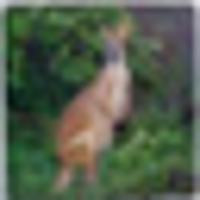

In [ ]:
# show the first image of the testing dataset
image = dataset_test["img"][3000].resize((200,200))
image

In [ ]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["fine_label"][3000]
labels = dataset_test.features['fine_label']
actual_label, labels.names[actual_label]

(38, 'kangaroo')

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = filepath
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits
    

In [ ]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['fine_label']
labels.names[predicted_label]

'kangaroo'